In [1]:
import gym
import matplotlib.pyplot as plt
import sys

sys.path.append('..')

from gym_minigrid_navigation.utils import show_video

plt.style.use('ggplot')

%load_ext autoreload
%autoreload 2

In [2]:
from torch import nn
import torch
import torch.nn.functional as F
import numpy as np

class StateEmbeddingNetwork(nn.Module):
    
    def __init__(self, action_size, state_size):
        super(StateEmbeddingNetwork, self).__init__()
        
        self.cnn = nn.Sequential(
            nn.Conv2d(state_size[2], 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU()
        )
        
        self.fc1 = nn.Linear(64*12*12, 32)
        self.fc2 = nn.Linear(2*32, 128)
        self.fc3 = nn.Linear(128, action_size)


    def forward(self, state, next_state):
        x = self.cnn(state.permute([0, 3, 1, 2]))
        x = x.view(x.size()[0], -1)
        
        x = F.relu(self.fc1(x))
        y = self.cnn(next_state.permute([0, 3, 1, 2]))
        y = y.view(y.size()[0], -1)
        y = F.relu(self.fc1(y))
        
        
        z = torch.cat((x, y), 1)
        z = F.relu(self.fc2(z))
        return F.log_softmax(self.fc3(z), dim=1)
    
    def embed(self, state):
        x = self.cnn(state.permute([0, 3, 1, 2]))
        x = x.view(x.size()[0], -1)
        x = F.relu(self.fc1(x))
        return x

In [3]:
device = "cpu"

def rollout(env, max_steps=False):
    
    states, next_states, actions = [],  [], []
    done = False
    
    state = env.reset()
    i = 0
    
    while not done:
        action = env.action_space.sample()
        next_state, reward, done, info = env.step(action)
        states.append(state)
        next_states.append(next_state)
        actions.append(action)
        state = next_state
        if i > max_steps and max_steps:
            break
        i+=1
    
    states = torch.from_numpy(np.array(states)).to(device, dtype=torch.float32)
    next_states = torch.from_numpy(np.array(next_states)).to(device, dtype=torch.float32)
    actions = torch.from_numpy(np.array(actions)).to(device)
    return states, next_states, actions

In [7]:
import gym_minigrid
from gym_minigrid.wrappers import FullyObsWrapper, RGBImgObsWrapper
from gym_minigrid_navigation.environments import ImgObsWrapper, FullyRenderWrapper

env = gym.make('MiniGrid-Dynamic-Obstacles-16x16-v0')
env = FullyRenderWrapper(FullyObsWrapper(env))
env = RGBImgObsWrapper(env)
env = ImgObsWrapper(env)

net = StateEmbeddingNetwork(action_size = env.action_space.n, state_size = env.observation_space["image"].shape)
optimizer = torch.optim.Adam(net.parameters(), lr=1e-4, weight_decay=1e-6)
nll_loss = nn.NLLLoss()


for roll in range(1000):
    
    states, next_states, actions = rollout(env)
    
    for epoch in range(5):
        optimizer.zero_grad()
        predicted_actions = net.forward(states, next_states)
        loss = nll_loss(predicted_actions, actions)
        loss.backward()
        optimizer.step()
    if roll%100==0: 
        print("Rollout: {0}, loss: {1}".format(roll, loss.item()))

Rollout: 0, loss: 0.9634482264518738
Rollout: 100, loss: 0.9293869137763977
Rollout: 200, loss: 1.0219241380691528
Rollout: 300, loss: 0.29028642177581787
Rollout: 400, loss: 0.005960027687251568
Rollout: 500, loss: 0.0006180757191032171
Rollout: 600, loss: 0.0011987985344603658
Rollout: 700, loss: 0.0007809791713953018
Rollout: 800, loss: 0.0025959385093301535
Rollout: 900, loss: 0.0007511568837799132


In [8]:
env = gym.make('MiniGrid-Dynamic-Obstacles-16x16-v0')
env = FullyRenderWrapper(FullyObsWrapper(env))
env = RGBImgObsWrapper(env)
env = ImgObsWrapper(env)

In [9]:
action = 2
state1, reward, done, info = env.step(action)

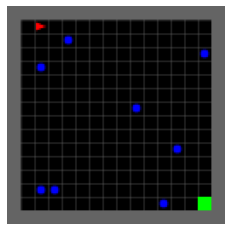

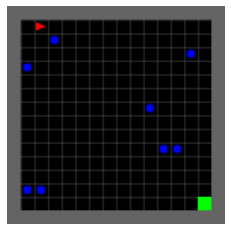

2.9733994007110596

In [13]:
state2, reward, done, info = env.step(1)

plt.axis(False)
plt.imshow(state1)
plt.show()
plt.axis(False)
plt.imshow(state2)
plt.show()
embed1 = net.embed(torch.from_numpy(np.array([state1])).to(device, dtype=torch.float32))
embed2 = net.embed(torch.from_numpy(np.array([state2])).to(device, dtype=torch.float32))
torch.dist(embed1, embed2, 2).detach().item()

# Learn go to controlable state

In [48]:
from collections import deque
import random
import numpy as np
from skimage.transform import rescale, resize

class FromBufferGoalWrapper(gym.Wrapper):
       
    def __init__(self, env, embedder, verbose=False):
        self.buffer = deque(maxlen=1000)
        self.embedder = embedder
        self.goal_state = None
        self.step_count = 0
        self.max_steps = 250
        self.verbose = verbose
        super().__init__(env)
    
    def reset(self):
        
        # Generate goal state
        self.step_count = 0
        if len(self.buffer) > 100:
            self.goal_state = random.sample(self.buffer, k=1)[0]
        
        return self.env.reset()

        
    def step(self, action):
        
        next_state, reward, done, info = self.env.step(action)
        self.buffer.append(next_state)       
        
        if self.goal_state is None:
            dist = 1000
        else:
            embed1 = self.embedder.embed(torch.from_numpy(np.array([self.goal_state])).to(device, dtype=torch.float32))
            embed2 = self.embedder.embed(torch.from_numpy(np.array([next_state])).to(device, dtype=torch.float32))
            dist = torch.dist(embed1, embed2, 2).detach().item()
        
        if dist < 5:
            reward = 1
        
            if self.verbose:
                print("Goal achieved in {0} steps, reward: {1}, dist: {2}".format(self.step_count, reward, dist))
                plt.subplot(1, 2, 1)
                plt.axis('off')
                plt.gca().set_title('Goal state')
                plt.imshow(self.goal_state)
                plt.subplot(1, 2, 2)
                plt.axis('off')
                plt.gca().set_title('Final state')
                plt.imshow(next_state)
                plt.show()  
                
            self.goal_state = random.sample(self.buffer, k=1)[0]
                
        if self.step_count > self.max_steps:
            done = True
             
        self.step_count += 1
        
        return next_state, reward, done, info

In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from collections import deque
import random

BATCH_SIZE = 128 # 128
UPDATE_STEP = 4 # 4
BUFFER_SIZE = 100000 # 100000
LEARNING_RATE = 1e-3 # 5e-3
GAMMA = 0.9 # 0.9
EPS_START = 1 # 1
EPS_END = 0.1 # 0.1
EPS_DECAY = 0.995 # 0.995
TAU=1e-3 # 1e-3

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Running on device: {}".format(device))

    
class MasterNetwork(nn.Module):
    """
    Simple multilayer network for DQN agent
    """

    def __init__(self, state_size,  emb_size, seed=42, hidden_size1=64, hidden_size2=64):
        super(MasterNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.layer1 = nn.Linear(state_size, hidden_size1)
        self.layer2 = nn.Linear(hidden_size1, hidden_size2)
        self.layer3 = nn.Linear(hidden_size2, emb_size)

    def forward(self, goal_states):
        x = F.relu(self.layer1(goal_states))
        x = F.relu(self.layer2(x))
        return torch.sigmoid(self.layer3(x))
    
class WorkerNetwork(nn.Module):
    """
    Simple multilayer network for DQN agent
    """

    def __init__(self, state_size, action_size, emb_size, seed=42, hidden_size1=64, hidden_size2=64):
        super(WorkerNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)    
        self.layer1 = nn.Linear(state_size, hidden_size1)
        self.layer2 = nn.Linear(hidden_size1, hidden_size2)
        self.layer3 = nn.Linear(emb_size + hidden_size2, hidden_size2)
        self.layer4 = nn.Linear(hidden_size2, action_size)

    def forward(self, states, embs):
        x = F.relu(self.layer1(states))
        x = F.relu(self.layer2(x))
        x = torch.cat((embs, x), 1)
        x = F.relu(self.layer3(x))
        return self.layer4(x)  
    

class MasterWorkerNetwork(nn.Module):
    """
    Master-Worker model
    """
    
    def __init__(self, state_size, action_size, emb_size=64, seed=42):
        super(MasterWorkerNetwork, self).__init__()
        self.master = MasterNetwork(state_size, emb_size)
        self.worker = WorkerNetwork(state_size, action_size, emb_size)
        
    def forward(self, states, goal_states):
        embs = self.master.forward(goal_states)
        return self.worker.forward(states, embs)


class DQNAgentGoal:
    """ An agent implementing Deep Q-Network algorithm"""
    
    def __init__(self, state_size, action_size, emb_size=64, seed=42):
        """Initializes an Agent.
        
        Params:
        -------
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            seed (int): random seed
        """
        self.qnetwork_local = MasterWorkerNetwork(state_size, action_size, emb_size).to(device)
        self.qnetwork_target = MasterWorkerNetwork(state_size, action_size, emb_size).to(device)
        self.qnetwork_target.load_state_dict(self.qnetwork_local.state_dict())
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=LEARNING_RATE)
        self.action_size = action_size
        self.buffer = deque(maxlen=BUFFER_SIZE) 
        self.step = 0
        self.eps = EPS_START
        self.explore = True
        
        
    def freeze_worker(self, learning_rate=LEARNING_RATE):
        for param in self.qnetwork_local.worker.parameters():
            param.requires_grad = False
            
        trainable = filter(lambda p: p.requires_grad, self.qnetwork_local.parameters())
        optimizer = optim.Adam(trainable, lr=learning_rate)
            
   
    def reset_episode(self):
        """
        Resets episode and update epsilon decay
        """
        self.eps = max(EPS_END, EPS_DECAY*self.eps) 
        
    def encode(self, raw_state):
        return rgb2gray(raw_state).flatten()
        
        
    def learn(self):
        """
        Learns values-actions network
        
        """
        
        # Sample batch from replay buffer
        states, next_states, goal_states, actions, rewards, dones = self.sample_batch()
        
        values = self.qnetwork_target.forward(next_states, goal_states).detach()
        targets = rewards + GAMMA * values.max(1)[0].view(dones.size()) * (1 - dones)
        outputs = self.qnetwork_local.forward(states, goal_states).gather(1, actions.long())
        self.optimizer.zero_grad()
        loss = F.mse_loss(outputs, targets)
        loss.backward()
        self.optimizer.step()
    
    
    def update(self, state, goal_state, action, reward, next_state, done):
        """
        Makes an update step of algorithm and append sars to buffer replay
        
        Params:
        -------
        state - current state
        action - action made
        reward - reward for an action
        next_state - next state from env
        done - episode finishing flag
        """
        state = self.encode(state)
        goal_state = self.encode(goal_state)
        next_state = self.encode(next_state)
        
        self.buffer.append((state, next_state, goal_state, action, reward, float(done)))
        
        self.step = (self.step+1)%UPDATE_STEP
        if self.step == 0:
            if len(self.buffer) > BATCH_SIZE:
                self.learn()
                self.reset_target_network()
        
        
    def reset_target_network(self):
        """
        Resets params of target network to values from local network
        """
        params = zip(self.qnetwork_target.parameters(), self.qnetwork_local.parameters())
        for target_param, local_param in params:
            updated_params = TAU*local_param.data + (1-TAU)*target_param.data
            target_param.data.copy_(updated_params)
        
        
    def act(self, state, goal_state):
        """
        Selects action from state if epsilon-greedy way
        
        Params:
        state - current state
        
        """
        
        state = self.encode(state)
        goal_state = self.encode(goal_state)
        
        self.step+=1
        
        self.qnetwork_local.eval()
        with torch.no_grad():
            action_values = self.qnetwork_local(torch.from_numpy(np.vstack([state])).float().to(device), 
                                                torch.from_numpy(np.vstack([goal_state])).float().to(device))  
        self.qnetwork_local.train()
            
        if (random.random() > self.eps) and self.explore:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))
        
    def sample_batch(self):
        """
        Samples a batch of experience from replay buffer random uniformily
        """
        batch = random.sample(self.buffer, k=BATCH_SIZE)
        f = lambda arr: torch.from_numpy(np.vstack(arr)).float().to(device)
        states, next_states, goal_states, actions, rewards, dones = map(f, zip(*batch))
        rewards = (rewards - rewards.mean()) / (rewards.std() + 1e-5)
        return states, next_states, goal_states, actions, rewards, dones

Running on device: cpu


In [16]:
from gym.wrappers import Monitor
from gym_minigrid_navigation.environments import FullyObsWrapper, FullyRenderWrapper, ImgObsWrapper
from utils import init_logger
from navigation_policy import run_episode, run_episodes


env = gym.make('MiniGrid-Dynamic-Obstacles-16x16-v0')
env = FullyRenderWrapper(FullyObsWrapper(env))
env = RGBImgObsWrapper(env)
env = ImgObsWrapper(env)
env = FromBufferGoalWrapper(env, net)
env = Monitor(env, './video', force=True)

In [17]:
env.reset()
done = False
while env.goal_state is None:
    a = env.action_space.sample()
    next_s, r, done, info = env.step(a)
    if done:
        env.reset()

In [20]:
state_size = len(next_s[:, 1:-1, 1:-1].flatten())
agent = DQNAgentGoal(state_size, action_size=env.action_space.n)
scores, steps = run_episodes(env, agent, None, n_episodes=1000, verbose=50)

Episode: 50. Average score: -0.86. Average steps: 9.10
Episode: 100. Average score: -0.74. Average steps: 22.00
Episode: 150. Average score: -0.76. Average steps: 18.72
Episode: 200. Average score: -0.62. Average steps: 25.72
Episode: 250. Average score: -0.70. Average steps: 42.84
Episode: 300. Average score: -0.56. Average steps: 46.08
Episode: 350. Average score: -0.44. Average steps: 57.80
Episode: 400. Average score: -0.44. Average steps: 62.98
Episode: 450. Average score: -0.34. Average steps: 76.30
Episode: 500. Average score: -0.32. Average steps: 98.82
Episode: 550. Average score: -0.30. Average steps: 75.82
Episode: 600. Average score: -0.10. Average steps: 68.60
Episode: 650. Average score: -0.14. Average steps: 82.66
Episode: 700. Average score: 0.36. Average steps: 72.22
Episode: 750. Average score: -0.02. Average steps: 75.26
Episode: 800. Average score: -0.44. Average steps: 88.94
Episode: 850. Average score: 0.00. Average steps: 98.24
Episode: 900. Average score: 0.10. 

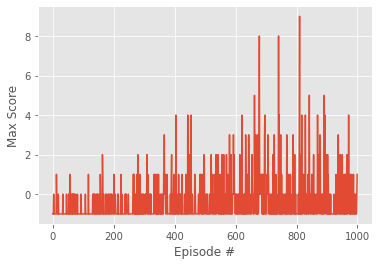

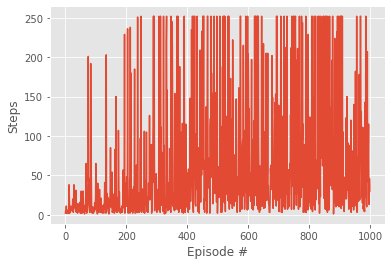

In [21]:
from utils import display_stats

display_stats(scores, steps)

Goal achieved in 1 steps, reward: 1, dist: 3.5758748054504395


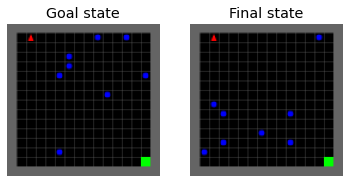

Goal achieved in 11 steps, reward: 1, dist: 2.695495843887329


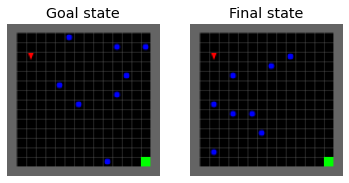

In [56]:
env = gym.make('MiniGrid-Dynamic-Obstacles-16x16-v0')
env = FullyRenderWrapper(FullyObsWrapper(env))
env = RGBImgObsWrapper(env)
env = ImgObsWrapper(env)
env = FromBufferGoalWrapper(env, net, verbose=True)
env = Monitor(env, './video', force=True)

env.reset()
done = False
while env.goal_state is None:
    a = env.action_space.sample()
    next_s, r, done, info = env.step(a)
    if done:
        env.reset()

run_episode(env, agent, train_mode=False)
show_video()